# Clusterização de crimes

Primeiramente vamos carregar os dados:

In [1022]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('Cluster-Crime-Maio.csv')
data.head(6)
#data['LATITUDE'].quantile([0, 0.25, 0.5, 0.75, 1])

,ID,FONTE,FLAGRANTE,NATUREZA DA OCORRÊNCIA,HISTÓRICO DA OCORRÊNCIA,LOCAL:,BAIRRO,SUSPEITO:,VEÍCULO:,VÍTIMA:,...,MATERIAL APREENDIDO:,PLACA:,VÍTIMAS LESIONADAS:,SUSPEITOS:,HORA,MINUTO,DATA,LATITUDE,LONGITUDE,CLUSTER
0,1,CIOPS,NÃO,MORTE - A BALA,"LOCAL: RUA CODO, JANGURUSSU. VÍTIMA: TIAGO S.P...","RUA CODO, JANGURUSSU",JANGURUSSU,nulo,nulo,TIAGO S,...,nulo,nulo,nulo,NÃO IDENTIFICADOS,10,37,01/05/17,-3.850046,-38.522390,30
1,2,CIOPS,NÃO,MORTE A BALA,"LOCAL: AV. LESTE OESTE, PIRAMBU. VÍTIMA: RAFAE...","AV. LESTE OESTE, PIRAMBU",PIRAMBU,nulo,nulo,RAFAEL RS,...,nulo,nulo,nulo,NÃO IDENTIFICADOS,11,50,01/05/17,-3.712388,-38.553322,0
2,3,CIOPS,NÃO,MORTE A BALA,"LOCAL: RUA TAILANDIA, GENIBAÚ. VÍTIMA: ISRAEL ...","RUA TAILANDIA, GENIBAU",GENIBAU,nulo,nulo,ISRAEL RA,...,nulo,nulo,nulo,NÃO IDENTIFICADOS,13,53,01/05/17,-3.758621,-38.604318,1
3,4,CIOPS,NÃO,MORTE A BALA,LOCAL: RUA DR JOAQUIM FROTA SAPIRANGA COITÉ. V...,RUA DR JOAQUIM FROTA SAPIRANGA COITE,RUA DR JOAQUIM FROTA SAPIRANGA COITE,nulo,nulo,DAVI M,...,nulo,nulo,nulo,NÃO IDENTIFICADOS,15,14,01/05/17,-3.801281,-38.472957,-1
4,5,CIOPS,NÃO,MORTE A BALA,"LOCAL: RUA CARNAUBAL, ALVARO WEYNE. VÍTIMA: DI...","RUA CARNAUBAL, ALVARO WEYNE",ALVARO WEYNE,nulo,nulo,DIEGO T,...,nulo,nulo,nulo,NÃO IDENTIFICADOS,17,42,01/05/17,-3.722553,-38.582816,2
5,6,CIOPS,NÃO,PORTE ILEGAL DE ARMA,"LOCAL:RUADEMETRIODEMENEZES,FLORESTA.SUSPEITOS:...","RUADEMETRIODEMENEZES,FLORESTA",FLORESTA,nulo,nulo,nulo,...,nulo,nulo,nulo,DOISMENOSRESDEIDADE,08,08,01/05/17,-3.734863,-38.584261,3


In [1023]:
points = data[['LATITUDE', 'LONGITUDE']]
points.head(4)

,LATITUDE,LONGITUDE
0,-3.850046,-38.522390
1,-3.712388,-38.553322
2,-3.758621,-38.604318
3,-3.801281,-38.472957


Plotando os pontos:

<Axes: xlabel='LATITUDE', ylabel='LONGITUDE'>

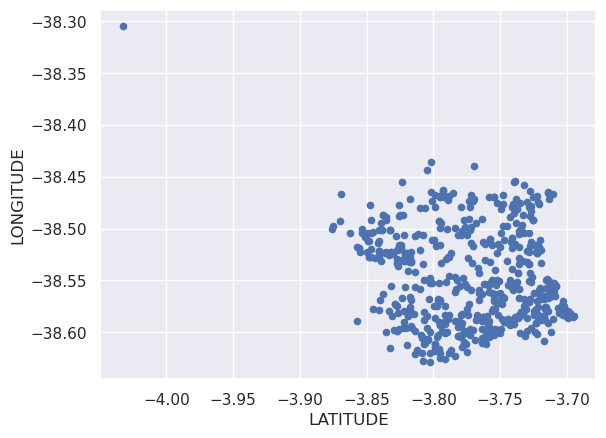

In [1024]:
points.plot.scatter(0, 1, style='o')

Calculando as distâncias dos vizinhos mais próximos de cada ponto:

Usarei um valor 4 para os vizinhos, buscando um valor médio que coincide com o número de samples usados no DBSCAN.

In [1025]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=4)
neigh.fit(points)

distances, indices = neigh.kneighbors(points)
#distances = distances[:, 1]
#distances, indices = distances[distances != 0], indices[distances != 0]
distances[:6]

array([[0.        , 0.00461222, 0.00463191, 0.00577241],
       [0.        , 0.        , 0.        , 0.00104886],
       [0.        , 0.        , 0.00310082, 0.00421748],
       [0.        , 0.00590589, 0.00633813, 0.00715768],
       [0.        , 0.00112388, 0.001894  , 0.00235304],
       [0.        , 0.00140801, 0.00146897, 0.00266621]])

Agora podemos usar as distâncias para remover outliers:

<Axes: xlabel='LATITUDE', ylabel='LONGITUDE'>

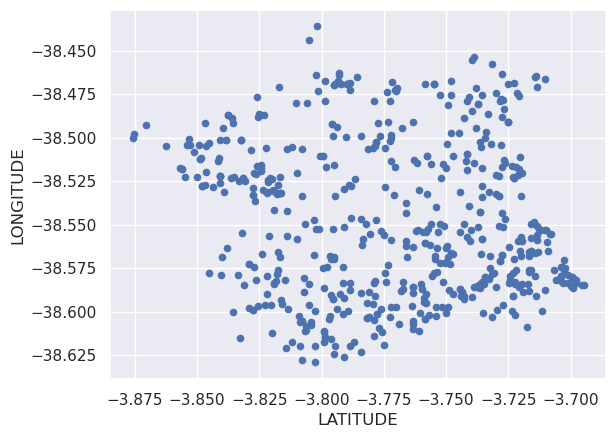

In [1026]:
firstnbr = distances[:, 1]
points = points.iloc[indices[firstnbr <
                             pd.DataFrame(firstnbr).quantile(0.99)[0]][:, 0]]
distances = distances[firstnbr < pd.DataFrame(firstnbr).quantile(0.99)[0]]
points.plot.scatter(0, 1, style='o')


Agora podemos buscar um valor para o eps, usaremos o primeiro quartil das distâncias:

0.0034996117556105027

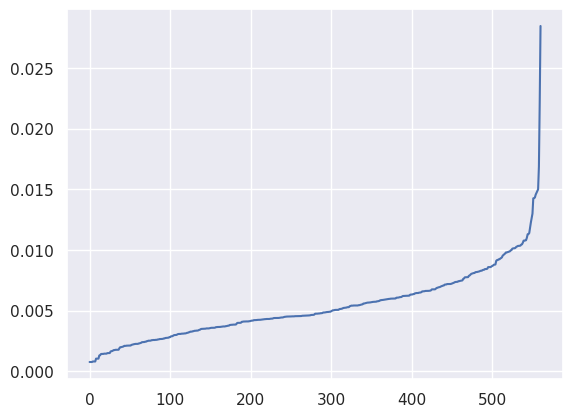

In [1027]:
nbrs = distances[:, 3]
plt.plot(np.sort(nbrs)[:])
eps = pd.DataFrame(nbrs).quantile(0.25)[0]
eps

In [1028]:
from sklearn.cluster import DBSCAN

def scan(eps, min_samples):
    m = DBSCAN(eps=eps, min_samples=min_samples, metric='haversine',
            metric_params=None, algorithm='auto', leaf_size=30, n_jobs=-1)
    return m.fit_predict(points)

In [1029]:
import folium
import matplotlib


def createMap(points, labels):
    cmap = plt.cm.get_cmap('hsv', pd.DataFrame(labels).nunique())
    fmap = folium.Map(prefer_canvas=True)

    def plotDot(p):
        c = (0.0, 0.0, 0.0, 0.5) if p.labels == -1 else cmap(int(p.labels))
        folium.CircleMarker(location=[p.LATITUDE, p.LONGITUDE],
                            radius=2,
                            weight=5,
                            color=matplotlib.colors.to_hex(c, keep_alpha=True)).add_to(fmap)

    colorpts = points.copy()
    colorpts['labels'] = labels
    colorpts.apply(plotDot, axis=1)

    fmap.fit_bounds(fmap.get_bounds())
    return fmap


labels = scan(eps, 4)
createMap(points, labels)


/tmp/ipykernel_1606/833417530.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('hsv', pd.DataFrame(labels).nunique())


Podemos ver vários clusters pequenos, mas a maior parte dos dados não foi considerada.

Podemos aumentar o epsilon para que mais pontos sejam considerados como vizinhança.

Aumentando a tolerância para o epsilon (usando a média) e aumentando o número de samples:

In [1030]:
eps = pd.DataFrame(nbrs).mean()[0]

labels = scan(eps, 6)
display(createMap(points, labels))


/tmp/ipykernel_1606/833417530.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('hsv', pd.DataFrame(labels).nunique())


Usando o kmeans:

In [1031]:
from sklearn.cluster import KMeans

numclusters = pd.DataFrame(labels).nunique()[0]
numclusters

kmm = KMeans(numclusters, random_state=42)
labels = kmm.fit_predict(points)
display(createMap(points, labels))


/home/gabriel/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0818a2a4d0>
Traceback (most recent call last):
  File "/home/gabriel/miniconda3/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/gabriel/miniconda3/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/gabriel/miniconda3/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/gabriel/miniconda3/lib/python3.10/site-packages/thread

A diferença que podemos observar é o fato de que todo ponto pertence a um cluster no kmeans, o que não é necessariamente verdade no dbscan.

Clusterização hierárquica:

In [1032]:
from sklearn.cluster import AgglomerativeClustering

aggm = AgglomerativeClustering(numclusters)
labels = aggm.fit_predict(points)
display(createMap(points, labels))


/tmp/ipykernel_1606/833417530.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('hsv', pd.DataFrame(labels).nunique())


Clusterização hierárquica teve resultados relativamente próximos do kmeans, com diferenças de alguns clusters que foram unidos em um e ficaram divididos em outro.